In [25]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# task a

In [27]:
df_sales = pd.read_csv("data/task4/Alcohol_Sales.csv")
df_sales.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [28]:
df_sales.shape

(325, 2)

In [29]:
df_sales.columns = ["DATE", "SALES"]

In [30]:
df_sales.head()

,DATE,SALES
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [31]:
df_sales.dtypes

DATE     object
SALES     int64
dtype: object

In [32]:
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'])
df_sales.set_index('DATE', inplace=True)

In [33]:
train_data, test_data = train_test_split(df_sales, test_size=0.2, shuffle=False)

In [34]:
scaler = StandardScaler()
train_data['SALES'] = scaler.fit_transform(train_data[['SALES']])
test_data['SALES'] = scaler.transform(test_data[['SALES']])


In [35]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        target = data.iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))  # Output layer for forecasting


In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


8/8 [==============================] - 1s 3ms/step - loss: 0.7659
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5342
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2941
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1965
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1887
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1705
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1717
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1636
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1631
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1614
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1612
Epoch 13/100
8/8 [==============================] - 0s 4ms/step - loss: 0

In [39]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame({'Train Predictions': train_predictions, 'Actuals': y_test.flatten()})
train_results.head()

2/2 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,3.168937,1.835890
1,2.375737,1.843094
2,1.849566,1.774208
3,1.803068,2.219486
4,2.142552,1.613026


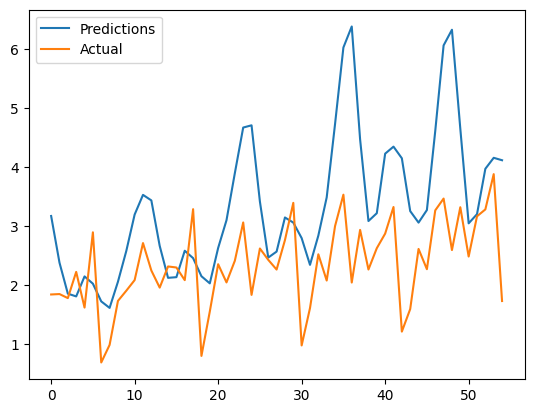

In [40]:
plt.plot(train_results['Train Predictions'][:100], label = "Predictions")
plt.plot(train_results['Actuals'][:100], label = "Actual")
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


2/2 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 1.4238993335298669


# task b

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [53]:
df_miles = pd.read_csv("data/task4/Miles_Traveled.csv")

In [54]:
df_miles.head(3)

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0


In [55]:
df_miles.columns = ["DATE", "MILES"]

In [56]:
df_miles['DATE'] = pd.to_datetime(df_miles['DATE'])
df_miles.sort_values(by='DATE', inplace=True)

In [57]:
df_miles.set_index('DATE', inplace=True)

In [58]:
df_miles

,MILES
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0
...,...
2018-08-01,286608.0
2018-09-01,260595.0
2018-10-01,282174.0


<Axes: xlabel='DATE'>

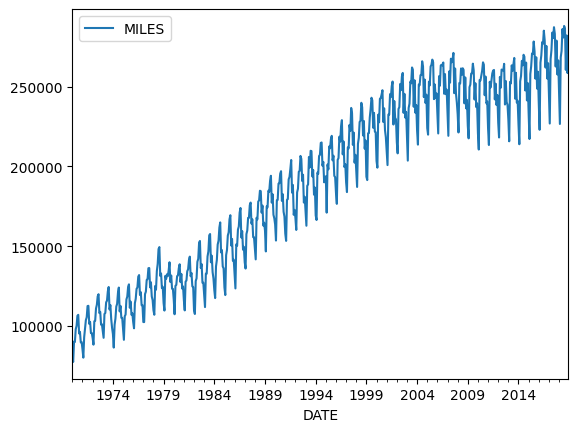

In [59]:
df_miles.plot()

In [74]:
# train_data, test_data = train_test_split(df_miles, test_size=0.3, shuffle=False)
# def create_sequences(data, sequence_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - sequence_length):
#         seq = data.iloc[i:i + sequence_length]
#         target = data.iloc[i + sequence_length]
#         sequences.append(seq)
#         targets.append(target)
#     return np.array(sequences), np.array(targets)

# sequence_length = 10
# X_train, y_train = create_sequences(train_data, sequence_length)
# X_test, y_test = create_sequences(test_data, sequence_length)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
# model.add(Dense(1))  # Output layer for forecasting

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, y_train, epochs=100, batch_size=32)


def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        # to make a list of list
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)

    return np.array(X), np.array(y)


In [86]:
X, y = df_to_X_y(df_miles, 12)
X.shape, y.shape

((576, 12, 1, 1), (576, 1))

In [87]:
# 70:30 split
split_index = int(len(df_miles) * 0.7)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

In [92]:
model = Sequential()
model.add(InputLayer((12,1)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [94]:
# get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [95]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, verbose = 0)

In [96]:

from sklearn.metrics import mean_squared_error

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

1/6 [====>.........................] - ETA: 1s

6/6 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 254353.2800190435


In [97]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame({'Train Predictions': train_predictions, 'Actuals': y_test.flatten()})
train_results

6/6 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,0.48179,250860.0
1,0.48179,262678.0
2,0.48179,263816.0
3,0.48179,267025.0
4,0.48179,265323.0
...,...,...
160,0.48179,286608.0
161,0.48179,260595.0
162,0.48179,282174.0
163,0.48179,258590.0


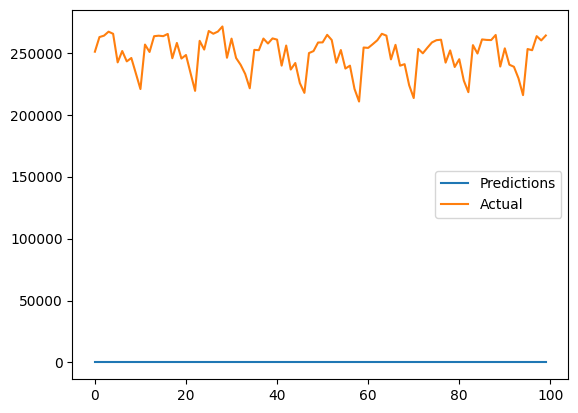

In [98]:
plt.plot(train_results['Train Predictions'][:100], label = "Predictions")
plt.plot(train_results['Actuals'][:100], label = "Actual")
plt.legend()
plt.show()